In [1]:
import tensorflow as tf
print(tf.__version__)


2.1.0


The next code block will set up the time series with seasonality, trend and a bit of noise. 

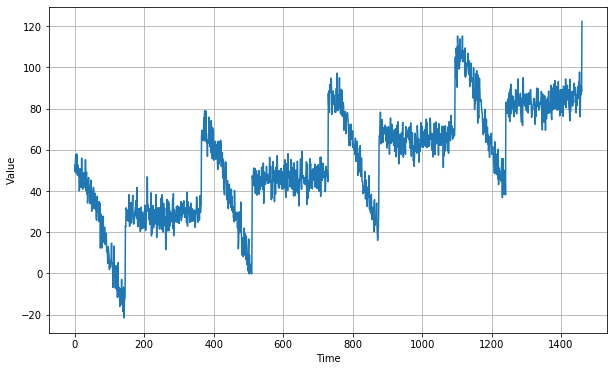

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

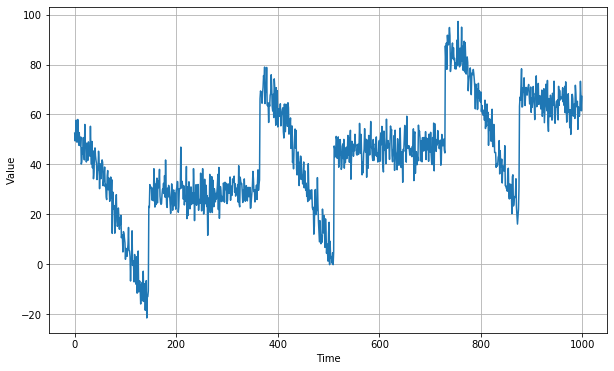

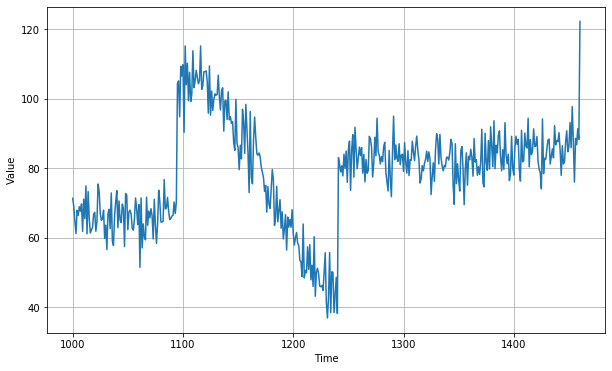

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [7]:

naive_forecast = series[split_time - 1:-1]
naive_forecast

array([ 67.19674 ,  71.34472 ,  68.98551 ,  64.6752  ,  61.15736 ,
        67.89844 ,  66.390305,  68.91469 ,  67.6307  ,  69.71901 ,
        61.81174 ,  71.091835,  65.51008 ,  74.91588 ,  61.11138 ,
        73.25516 ,  65.58317 ,  61.35506 ,  62.21152 ,  63.048264,
        66.79013 ,  67.30303 ,  61.840164,  64.60695 ,  75.460365,
        73.40727 ,  66.971954,  65.00137 ,  65.43278 ,  67.9217  ,
        59.761875,  63.610905,  56.577053,  66.938515,  68.20101 ,
        62.571968,  72.88092 ,  58.905464,  57.73595 ,  66.20383 ,
        70.34101 ,  73.54933 ,  62.859653,  70.57207 ,  65.010925,
        64.36533 ,  69.671974,  68.5407  ,  57.42275 ,  72.71323 ,
        72.256996,  62.25493 ,  67.38817 ,  67.9059  ,  66.7659  ,
        62.737984,  62.15856 ,  65.41626 ,  71.43522 ,  68.31729 ,
        63.774124,  69.51377 ,  51.440834,  71.45582 ,  57.042038,
        63.957195,  60.20002 ,  59.354107,  71.66096 ,  63.547802,
        67.648476,  65.71117 ,  68.36095 ,  66.39001 ,  59.621

In [8]:
x_valid

array([ 71.34472 ,  68.98551 ,  64.6752  ,  61.15736 ,  67.89844 ,
        66.390305,  68.91469 ,  67.6307  ,  69.71901 ,  61.81174 ,
        71.091835,  65.51008 ,  74.91588 ,  61.11138 ,  73.25516 ,
        65.58317 ,  61.35506 ,  62.21152 ,  63.048264,  66.79013 ,
        67.30303 ,  61.840164,  64.60695 ,  75.460365,  73.40727 ,
        66.971954,  65.00137 ,  65.43278 ,  67.9217  ,  59.761875,
        63.610905,  56.577053,  66.938515,  68.20101 ,  62.571968,
        72.88092 ,  58.905464,  57.73595 ,  66.20383 ,  70.34101 ,
        73.54933 ,  62.859653,  70.57207 ,  65.010925,  64.36533 ,
        69.671974,  68.5407  ,  57.42275 ,  72.71323 ,  72.256996,
        62.25493 ,  67.38817 ,  67.9059  ,  66.7659  ,  62.737984,
        62.15856 ,  65.41626 ,  71.43522 ,  68.31729 ,  63.774124,
        69.51377 ,  51.440834,  71.45582 ,  57.042038,  63.957195,
        60.20002 ,  59.354107,  71.66096 ,  63.547802,  67.648476,
        65.71117 ,  68.36095 ,  66.39001 ,  59.62124 ,  71.048

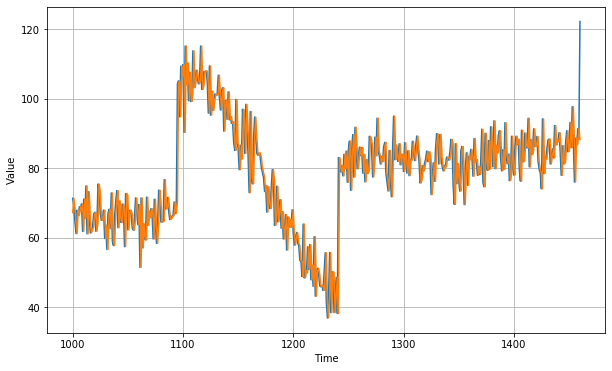

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

[71.34472  68.98551  64.6752   61.15736  67.89844  66.390305 68.91469
 67.6307   69.71901  61.81174 ]
[67.19674  71.34472  68.98551  64.6752   61.15736  67.89844  66.390305
 68.91469  67.6307   69.71901 ]


Let's zoom in on the start of the validation period:

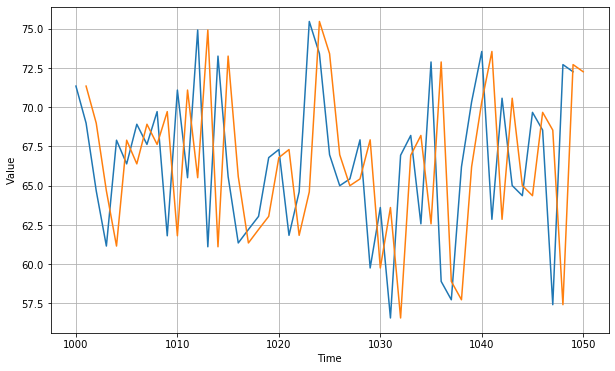

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start=0,end=50)
plot_series(time_valid, naive_forecast,start=1,end=51)

In [17]:
x_valid[9]

61.81174

You can see that the naive forecast lags 1 step behind the time series.

In [23]:
a = np.array([1,1,1,1,1,1])
b = np.array([2,2,2,2,2,2])

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [27]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.9379086


In [29]:
print(naive_forecast[:10])
print(x_valid[:10])

[67.19674  71.34472  68.98551  64.6752   61.15736  67.89844  66.390305
 68.91469  67.6307   69.71901 ]
[71.34472  68.98551  64.6752   61.15736  67.89844  66.390305 68.91469
 67.6307   69.71901  61.81174 ]


That's our baseline, now let's try a moving average:

In [41]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

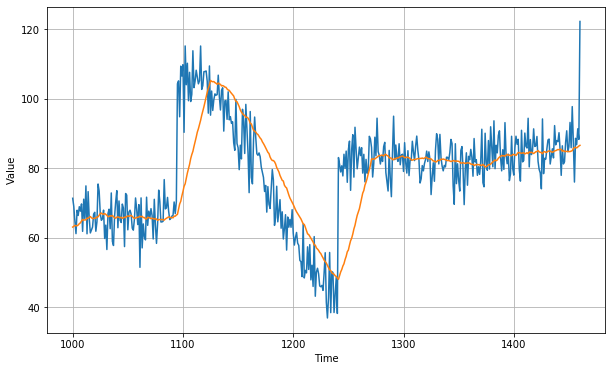

In [52]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

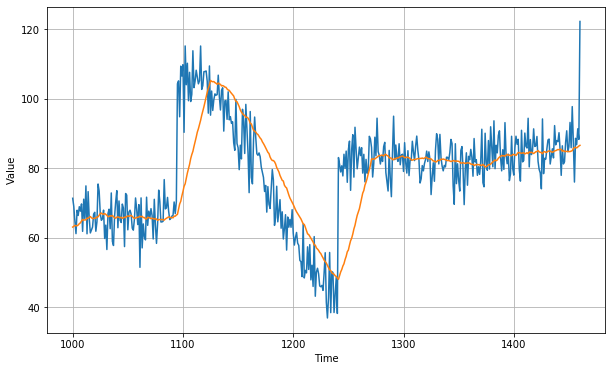

In [45]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [53]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

In [62]:
print(series[365:].shape)
print(series[:-365].shape)

(1096,)
(1096,)


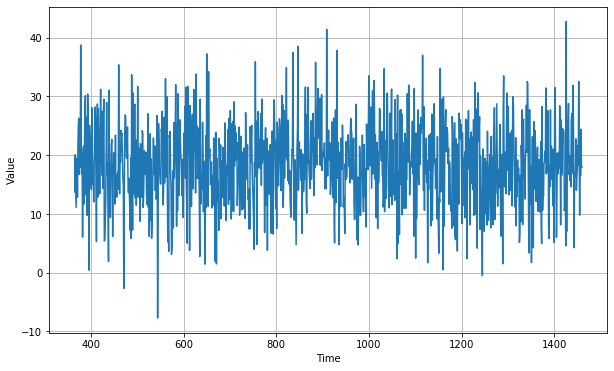

In [63]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

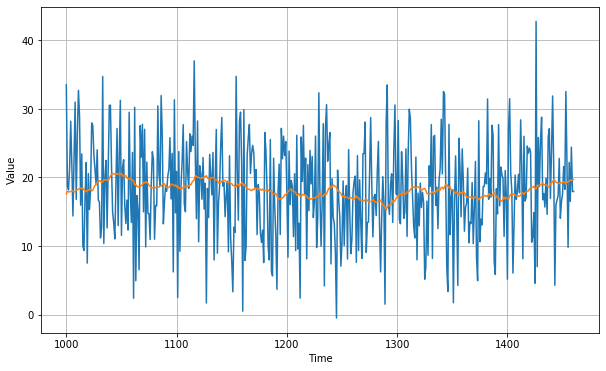

In [64]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

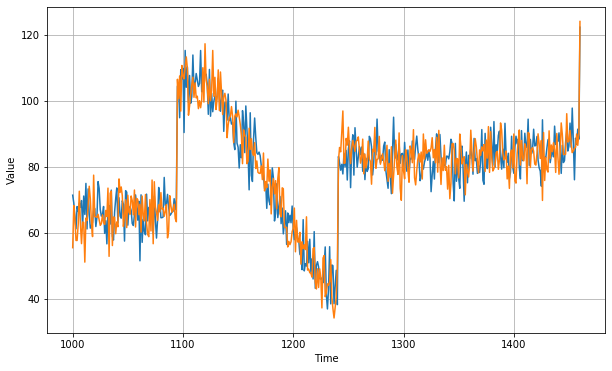

In [65]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [66]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973656
5.8393106


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

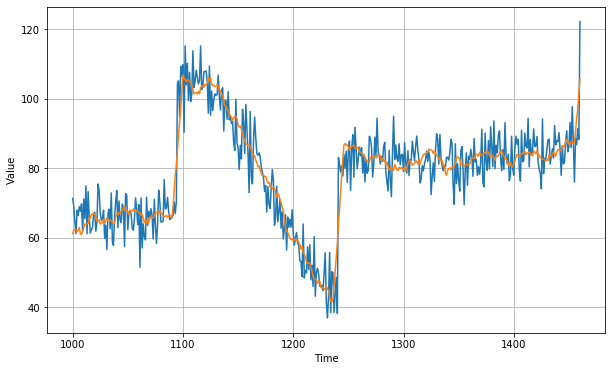

In [67]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [68]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442
